In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import ndiffs, nsdiffs
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [2]:
symbol = '^GSPC' # input
start = '2012-01-01' # input 
end = '2022-07-21'  # input
df = yf.download(symbol, start, end)

[*********************100%***********************]  1 of 1 completed


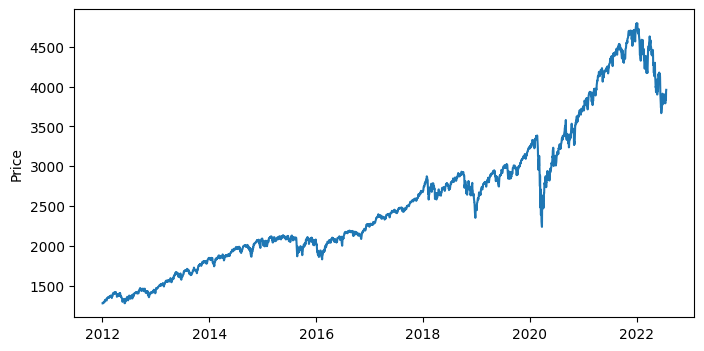

In [3]:
plt.figure(figsize=(8,4))
plt.plot(df['Close'])
plt.ylabel('Price')
plt.show()

In [4]:
df = df.reset_index()
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Close'].values
y_test = test_data['Close'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

2123 train samples
531 test samples


In [5]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [6]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19616.274, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19732.338, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19646.927, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19664.179, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19733.037, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19618.599, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19626.080, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19614.490, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19555.878, Time=0.97 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19618.596, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=19547.153, Time=1.32 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=19611.996, Time=0.52 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(1,1,5)(0,0,0)[0] interce

In [7]:
print(auto.order)

(2, 1, 5)


In [8]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 2121.2042655334567
SMAPE: 0.8622464374067019


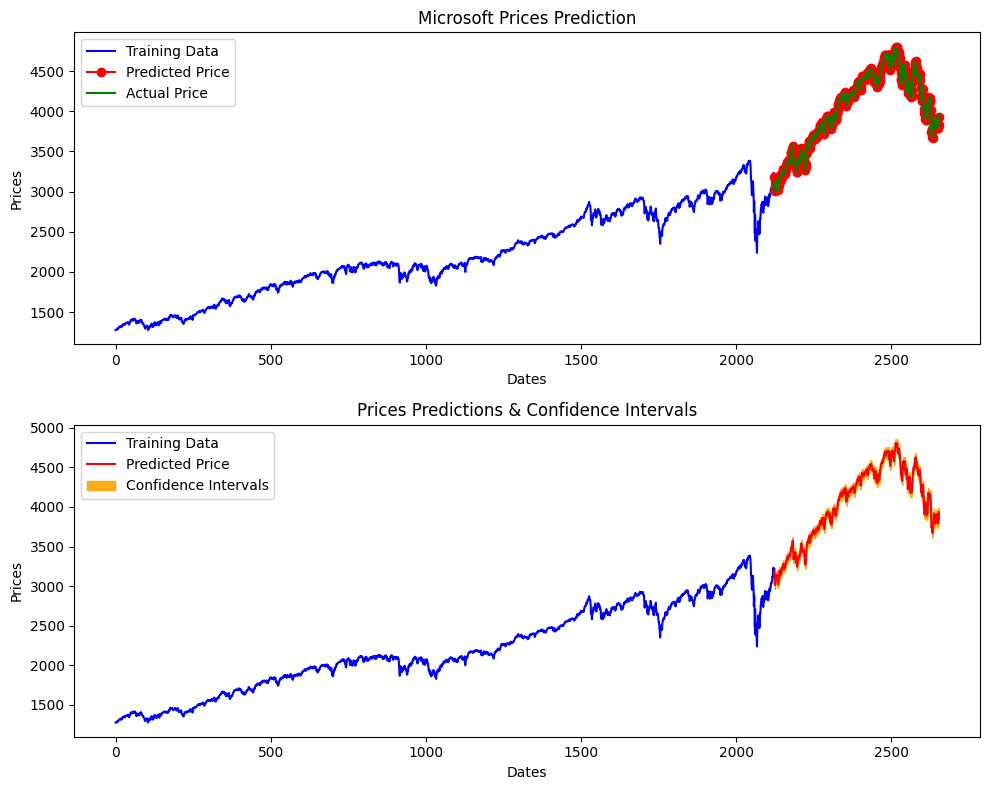

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='red', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='green', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 1500, 800).tolist(), df['Date'][0:1500:800].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='red',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 1500, 800).tolist(), df['Date'][0:1500:800].tolist())
axes[1].legend()
fig.tight_layout()